In [58]:
import matplotlib.pyplot as plt
import numpy as np
import functools 

In [59]:
from enum import Enum


class Set:
    class SetType(Enum):
        CONTINUOUS = 1
        DISCRETE = 2

    def __init__(self, type: SetType, values: any):
        self.type = type
        self.values = values

    def get_coverage(self, grid_size: int):
        if self.type == Set.SetType.CONTINUOUS:
            return np.linspace(self.values[0], self.values[1], grid_size)
        elif self.type == Set.SetType.DISCRETE:
            return self.values


def make_continuousSet(range: tuple[float, float]):
    return Set(Set.SetType.CONTINUOUS, range)


def make_discrete(values: list[float]):
    return Set(Set.SetType.DISCRETE, values)


class CrispSet:
    def __init__(self, dimensions: set[tuple[str, Set]]):
        """
        A class representing a crisp set.

        dimensions: [(name, (min, max))] A list of tuples where the first element is the name of the dimension and the second element is a tuple representing the minimum and maximum value of the dimension.
        With the help of the cartesian product, the dimensions get combined.
        """
        self.dimensions = dimensions

    def __mul__(self, other):
        """
        The cartesian product of two crisp sets.
        """
        new_dimensions = set()
        new_dimensions.update(self.dimensions)
        new_dimensions.update(other.dimensions)

        return CrispSet(new_dimensions)

    def __repr__(self):
        return str(self.dimensions)

In [60]:
class FuzzySet:
    def __init__(self, linguistic_term: str, function: callable, based_on: list = [], is_base_set=False, crisp_set: CrispSet = None) -> None:
        """
        A class to represent a fuzzy set.

        linguistic_term: The name of the fuzzy set. (e.g. "young")
        crisp_set: The crisp set that the fuzzy set is defined over.
        function: A function that takes a value and returns the membership value of that value in the fuzzy set.
        based_on: A list of fuzzy sets that this fuzzy set is based on. This is used for plotting purposes.
        """
        self.linguistic_term = linguistic_term
        self.crisp_set = crisp_set
        self.function = function
        self.based_on = based_on
        self.is_base_set = is_base_set

    def __call__(self, data):
        if self.is_base_set:
            # Function is a direct function of the input data
            assert len(
                self.crisp_set.dimensions) == 1, "Can only evaluate fuzzy sets over one variable"
            (name, _) = next(iter(self.crisp_set.dimensions))
            assert name in data, f"Missing input {name}"
            return self.function(data[name])
        else:
            # Function is a function a lambda function combining other fuzzy sets
            # Pass the data down recursively
            return self.function(data)

    def center_of_gravity(self, numpoints=100):
        """
        Calculate the center of gravity of the fuzzy set.

        Returns: (x,y) The x and y coordinates of the center of gravity.
        Uses the range of the crisp set to calculate the center of gravity numerically.
        """
        assert len(
            self.crisp_set.dimensions) == 1, "Can only calculate center of gravity for one variable"
        (name, set) = next(iter(self.crisp_set.dimensions))

        numX = 0
        numY = 0
        den = 0

        for x in set.get_coverage(numpoints):
            y = self.function({name: x})
            numX += x*y
            numY += 0.5*y*y
            den += y

        if den == 0:
            return (0, 0)

        return (numX/den, numY/den)

    def __and__(self, other):
        """
        The intersection of two fuzzy sets.
        """
        new_linguistic_term = f"({self.linguistic_term} and {other.linguistic_term})"
        new_crisp_set = self.crisp_set * other.crisp_set
        return FuzzySet(new_linguistic_term, lambda data: min(self(data), other(data)), [self, other], crisp_set=new_crisp_set)

    def __or__(self, other):
        """
        The union of two fuzzy sets.
        """
        new_linguistic_term = f"({self.linguistic_term} or {other.linguistic_term})"
        new_crisp_set = self.crisp_set * other.crisp_set
        return FuzzySet(new_linguistic_term, lambda data: max(self(data), other(data)), [self, other], crisp_set=new_crisp_set)

    def __invert__(self):
        """
        The negation of a fuzzy set.
        """
        new_linguistic_term = f"(not {self.linguistic_term})"
        new_crisp_set = self.crisp_set
        return FuzzySet(new_linguistic_term, lambda data: 1 - self(data), [self], crisp_set=new_crisp_set)

    def plot(self, ax):
        assert len(
            self.crisp_set.dimensions) == 1, "Can only plot fuzzy sets over one variable"
        [name, set] = next(iter(self.crisp_set.dimensions))
        xrange = set.get_coverage(1000)

        for mf in self.based_on:
            [_, mf_set] = next(iter(mf.crisp_set.dimensions))
            yh = [mf({name: x}) for x in xrange]

            if mf_set.type == Set.SetType.DISCRETE:
                total_range = max(mf_set.values) - min(mf_set.values)
                ax.bar(xrange, yh, label=mf.linguistic_term,
                       width=total_range/(50*len(mf_set.values)), alpha=0.5)
            else:
                ax.plot(xrange, yh, label=mf.linguistic_term,
                        linestyle='--', alpha=0.5, linewidth=0.5)

        y = [self({name: x}) for x in xrange]

        if set.type == Set.SetType.DISCRETE:
            total_range = max(set.values) - min(set.values)
            ax.bar(xrange, y, label=self.linguistic_term,
                   width=total_range/(50*len(set.values)))
        else:
            ax.plot(xrange, y, label=self.linguistic_term)

        if len(self.based_on) > 0:
            if set.type == Set.SetType.CONTINUOUS:
                ax.fill_between(xrange, 0, y, alpha=0.25)
            (cog_x, cog_y) = self.center_of_gravity()
            ax.axvline(cog_x, color='black', linestyle='--')
            ax.plot([cog_x], [cog_y], marker='o', markersize=5, color="black",
                    label=f"Center of Gravity: ({cog_x:.2f}, {cog_y:.2f})")

        ax.set_title(f"Linguistic Term: {self.linguistic_term}")
        ax.set_xlabel(name)
        ax.set_ylabel("Membership Value")

        ax.legend()

    def __repr__(self):
        return f"FuzzySet({self.crisp_set} -> {self.linguistic_term})"

# Some Concrete Membership Functions

In [61]:
class Triangle(FuzzySet):

    def __init__(self, linguistic_term, center, width):
        """
        A class representing a triangular fuzzy set.

        linguistic_term: The name of the fuzzy set. (e.g. "young")
        center: The center of the fuzzy set. (The point where the membership value is 1)
        width: The width of the triangular shape. (Half of the base of the triangle) (The points where the membership value is 0)
        """

        self.center = center
        self.width = width
        def function(x): return max(0, 1 - abs(x - center) / width)
        super().__init__(linguistic_term, function, is_base_set=True)


class Trapezoid(FuzzySet):

    def __init__(self, linguistic_term, left, center_left, center_right, right):
        """
        A class representing a trapezoidal fuzzy set.

        linguistic_term: The name of the fuzzy set. (e.g. "young")
        left: The left edge of the fuzzy set. (The point where the membership value is 0)
        center_left: The left center of the fuzzy set. (The point where the membership value is 1)
        center_right: The right center of the fuzzy set. (The point where the membership value is 1)
        right: The right edge of the fuzzy set. (The point where the membership value is 0)
        """

        self.left = left
        self.center_left = center_left
        self.center_right = center_right
        self.right = right

        if (self.left == self.center_left):
            self.left -= 0.001
        if (self.right == self.center_right):
            self.right += 0.001

        def function(x): return max(0, min((x - self.left) / (self.center_left -
                                                              self.left), 1, (self.right - x) / (self.right - self.center_right)))
        super().__init__(linguistic_term, function, is_base_set=True)


class Gaussian(FuzzySet):

    def __init__(self, linguistic_term, mean, sigma):
        """
        A class representing a Gaussian fuzzy set.

        linguistic_term: The name of the fuzzy set. (e.g. "young")
        mean: The mean of the Gaussian. (The point where the membership value is 1)
        sigma: The standard deviation of the Gaussian. (The width of the Gaussian)
        """

        self.mean = mean
        self.sigma = sigma
        def function(x): return np.exp(-0.5 * ((x - mean) / sigma) ** 2)
        super().__init__(linguistic_term, function, is_base_set=True)


class Singleton(FuzzySet):

    def __init__(self, linguistic_term, value):
        """
        A class representing a singleton fuzzy set.

        linguistic_term: The name of the fuzzy set. (e.g. "young")
        value: The value of the singleton fuzzy set. (The point where the membership value is 1)
        """

        def function(x): return 1 if x == value else 0
        super().__init__(linguistic_term, function, is_base_set=True)

In [62]:
class LinguisticVariable:
    def __init__(self, crisp_set: CrispSet) -> None:
        """
        A class to represent a fuzzy variable.

        crisp_set: The name of the crisp set. (e.g. "age")
        """
        self.crisp_set = crisp_set
        self.linguistic_terms: dict[str, FuzzySet] = dict()

    def add_linguistic_term(self, fuzzySet: FuzzySet):
        fuzzySet.crisp_set = self.crisp_set
        self.linguistic_terms[fuzzySet.linguistic_term] = fuzzySet

    def plot(self, ax):
        assert len(self.crisp_set.dimensions) == 1, "Can only plot fuzzy sets over one variable"
        [name,_]= next(iter(self.crisp_set.dimensions))
        for mf in self.linguistic_terms.values():
            mf.plot(ax)
        ax.set_title(f'Linguistic Variable: {name}')
        ax.set_xlabel(name)
        ax.set_ylabel('Membership Degree')
        ax.legend()

    def __eq__(self, name:str):
        """
        Overload the equality operator to return a linguistic term by name.
        """
        return self.linguistic_terms[name]
    
    def __repr__(self):
        return f"FuzzyVariable({self.crisp_set}) with sets: [{', '.join(self.linguistic_terms)}]"

# Create Some Fuzzy Variables

In [63]:
age_crisp_set = CrispSet({("age", make_continuousSet((0, 80)))})
age = LinguisticVariable(age_crisp_set)

age.add_linguistic_term(Trapezoid("young", 0, 0, 20, 40))
age.add_linguistic_term(Gaussian("middle", 40, 10))
age.add_linguistic_term(Trapezoid("old", 50, 60, 80, 80))

In [64]:
height_crisp_set = CrispSet({("height", make_continuousSet((0, 240)))})
height = LinguisticVariable(height_crisp_set)

height.add_linguistic_term(Trapezoid("short", 0, 0, 150, 160))
height.add_linguistic_term(Trapezoid("medium", 150, 170, 180, 200))
height.add_linguistic_term(Trapezoid("tall", 190, 220, 240, 240))

In [65]:
fitness_crisp_set = CrispSet({("fitness", make_discrete([0, 0.5, 1]))})
fitness = LinguisticVariable(fitness_crisp_set)

# fitness.add_linguistic_term(Gaussian("low",0, 0.2))
# fitness.add_linguistic_term(Gaussian("medium", 0.5, 0.2))
# fitness.add_linguistic_term(Gaussian("high",1, 0.2))

fitness.add_linguistic_term(Singleton("low", 0))
fitness.add_linguistic_term(Singleton("medium", 0.5))
fitness.add_linguistic_term(Singleton("high", 1))

# Plot Variables

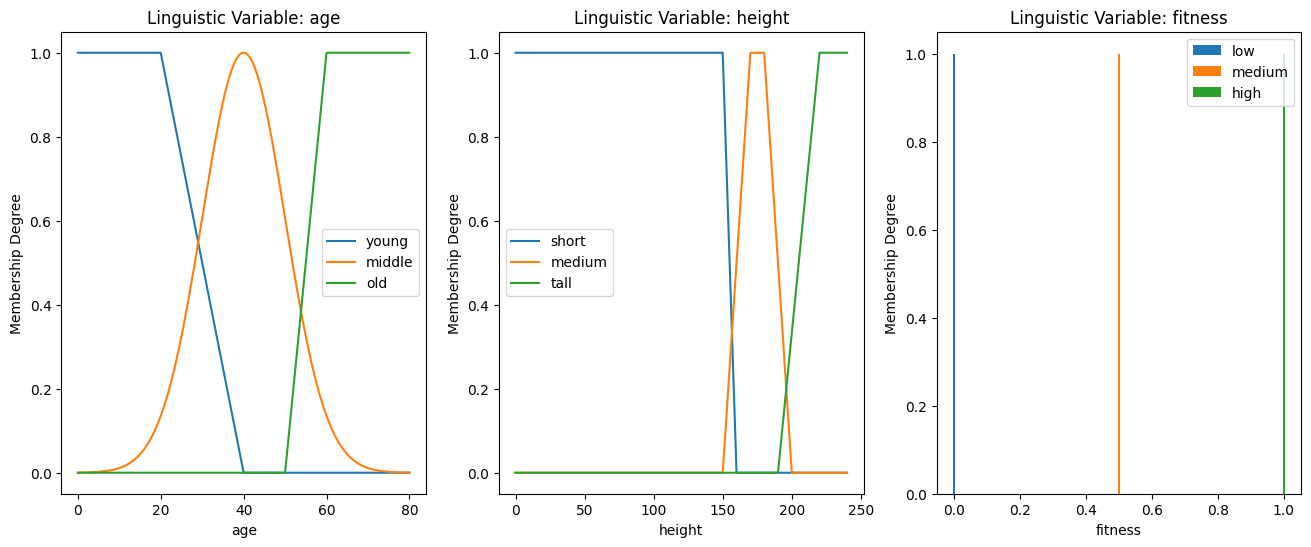

In [66]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(16, 6)

age.plot(ax[0])
height.plot(ax[1])
fitness.plot(ax[2])

plt.show()

In [67]:
def plot3D_surface(input_sets: set[CrispSet], function: callable, axesMap: dict, mesh=15, contour_levels=30):
    fig = plt.figure()
    axs = fig.subplot_mosaic([['A', 'B']])
    fig.set_size_inches(16, 6)

    nameX = axesMap['x']
    nameY = axesMap['y']
    nameZ = axesMap['z']

    setX = make_continuousSet((0, 1))
    setX = make_continuousSet((0, 1))

    # Find the dimensions of the input sets that correspond to the x and y axes
    for set in input_sets:
        for dim in set.dimensions:
            if dim[0] == nameX:
                (nameX, setX) = dim
            if dim[0] == nameY:
                (nameY, setY) = dim

    xs = setX.get_coverage(mesh)
    ys = setY.get_coverage(mesh)

    X, Y = np.meshgrid(xs, ys)
    Z = np.array([[function({nameX: x, nameY: y}) for x in xs] for y in ys])

    ss = axs['A'].get_subplotspec()
    axs['A'].remove()
    axs['A'] = fig.add_subplot(ss, projection='3d')
    axs['A'].plot_surface(X, Y, Z, cmap='viridis')
    axs['A'].set_xlabel(nameX)
    axs['A'].set_ylabel(nameY)
    axs['A'].set_zlabel(nameZ)

    countour = axs['B'].contourf(X, Y, Z, levels=contour_levels)
    axs['B'].set_title
    axs['B'].set_xlabel(nameX)
    axs['B'].set_ylabel(nameY)

    fig.suptitle(f"Surface and Contour plot of {nameZ}")
    fig.colorbar(countour, ax=axs['B'])

    return fig

In [68]:
class FuzzyRule:
    def __init__(self, antecedent: FuzzySet, consequent: FuzzySet):
        """
        A class representing a fuzzy rule.

        antecedent: The antecedent of the rule. (The condition)
        consequent: The consequent of the rule. (The action)
        """

        self.antecedent = antecedent
        self.consequent = consequent


    def apply(self, data: dict)->FuzzySet:
        """
        Apply the fuzzy rule to the data.
        Calculates the cut of the antecedent and returns the consequent with the cut applied.

        data: The input data to apply the rule to.
        """
        cut = self.antecedent(data)

        linguistic_term = f"{self.consequent.linguistic_term}↑{cut:.2f}"
        crisp_set = self.consequent.crisp_set

        cut_consequent= FuzzySet(linguistic_term, lambda data: min(cut, self.consequent(data)), [self.consequent],crisp_set=crisp_set)

        return cut_consequent


    def plot(self,axesMap:dict):
        new_map=axesMap.copy()
        new_map.update({"z":self.antecedent.linguistic_term})
        inputs=set()
        inputs.add(self.antecedent.crisp_set)

        fig = plot3D_surface(inputs,self.antecedent, new_map,mesh=30, contour_levels=30)
        return fig

    def __repr__(self):
        return f"FuzzyRule(IF {self.antecedent} THEN {self.consequent})"


# Plot Rule Input

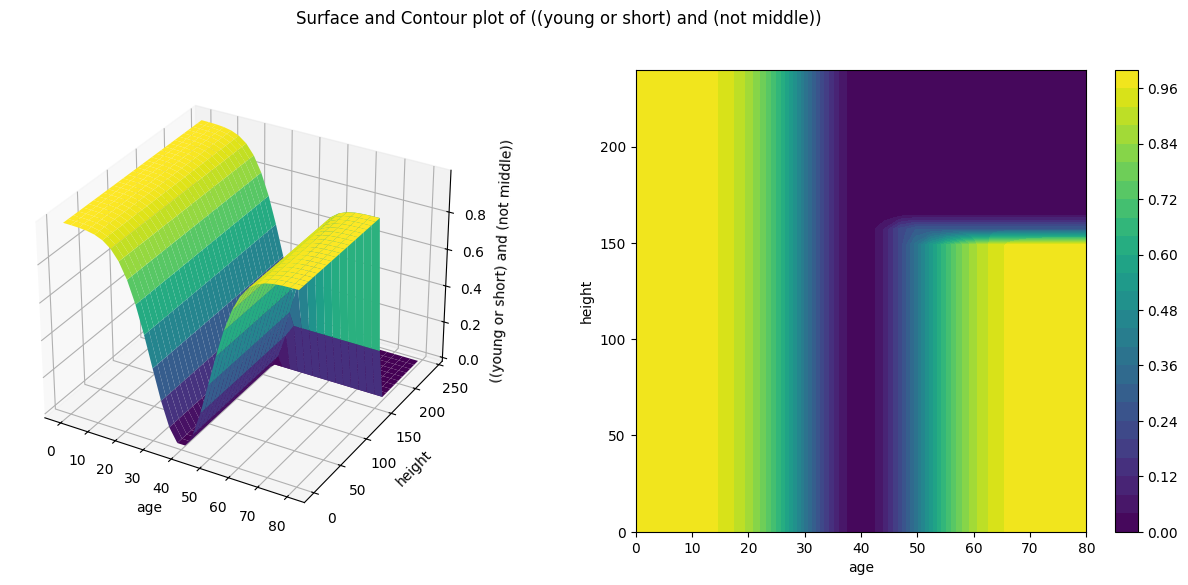

In [69]:
rule1= FuzzyRule(((age=="young") | (height=="short")) & (~(age=="middle")), fitness=="low")

rule1.plot({"x": "age", "y": "height"});

In [70]:
output1=rule1.apply({"age": 30, "height": 75})

output1

FuzzySet({('fitness', <__main__.Set object at 0x7f2dd9f77be0>)} -> low↑0.39)

# Plot Cut Result Variable

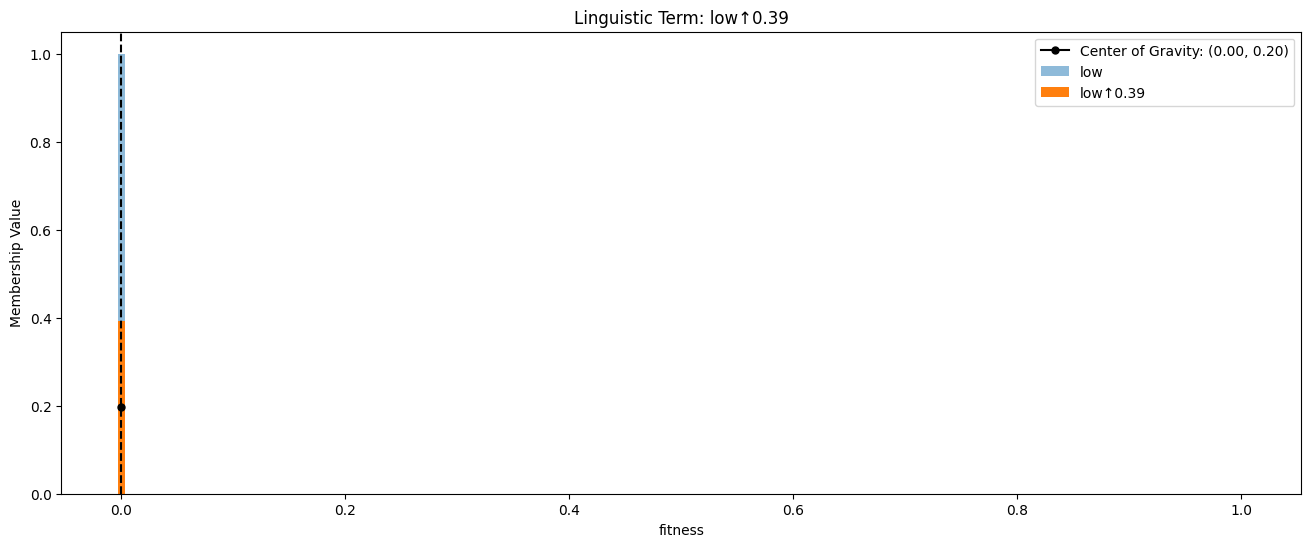

In [71]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

output1.plot(ax)

ax.legend()

In [72]:
class FuzzySystem:
    def __init__(self):
        self.rules: list[FuzzyRule] = []
        self.consequent: FuzzySet = None

    def add_rule(self, rule: FuzzyRule):
        if self.consequent is None:
            self.consequent = rule.consequent
        else:
            assert self.consequent.crisp_set == rule.consequent.crisp_set, "All rules must have the same consequent type"

        self.rules.append(rule)

    def applyRules(self, data: dict):
        """
        Apply all the rules to the data and return the union of the consequents.
        """

        cut_cut_consequents = [rule.apply(data) for rule in self.rules]

        union = functools.reduce(lambda x, y: x | y, cut_cut_consequents)

        all_based_on = []
        for consequents in cut_cut_consequents:
            all_based_on.extend(consequents.based_on)

        union.based_on = list(set(all_based_on))

        return union

    def predict(self, data: dict):
        """ 
        Apply the rules to the data and return the center of gravity of the union of the consequents.
        This is also the prediction of the fuzzy system for given data

        data: The input data to predict on.
        """

        union = self.applyRules(data)
        (cx,cy)= union.center_of_gravity()
        return cx
    

    def getInputCrispSets(self):
        inputs = set()
        for rule in self.rules:
            inputs.add(rule.antecedent.crisp_set)
        return inputs

    def __repr__(self):
        newline="\n"
        return f"FuzzySystem with rules:\n\n{newline.join(map(str,self.rules))}"


# Resulting System

In [73]:
fs = FuzzySystem()

fs.add_rule(FuzzyRule((age=="young"), fitness=="high"))
fs.add_rule(FuzzyRule((age=="old") & (height=="short"), fitness=="low"))
fs.add_rule(FuzzyRule((age=="middle") & (height=="medium"), fitness=="medium"))
fs.add_rule(FuzzyRule((age=="middle") & (height=="tall"), fitness=="high"))
fs.add_rule(FuzzyRule((age=="old") & (height=="tall"), fitness=="low"))

# Plot Fitnes at a specific point

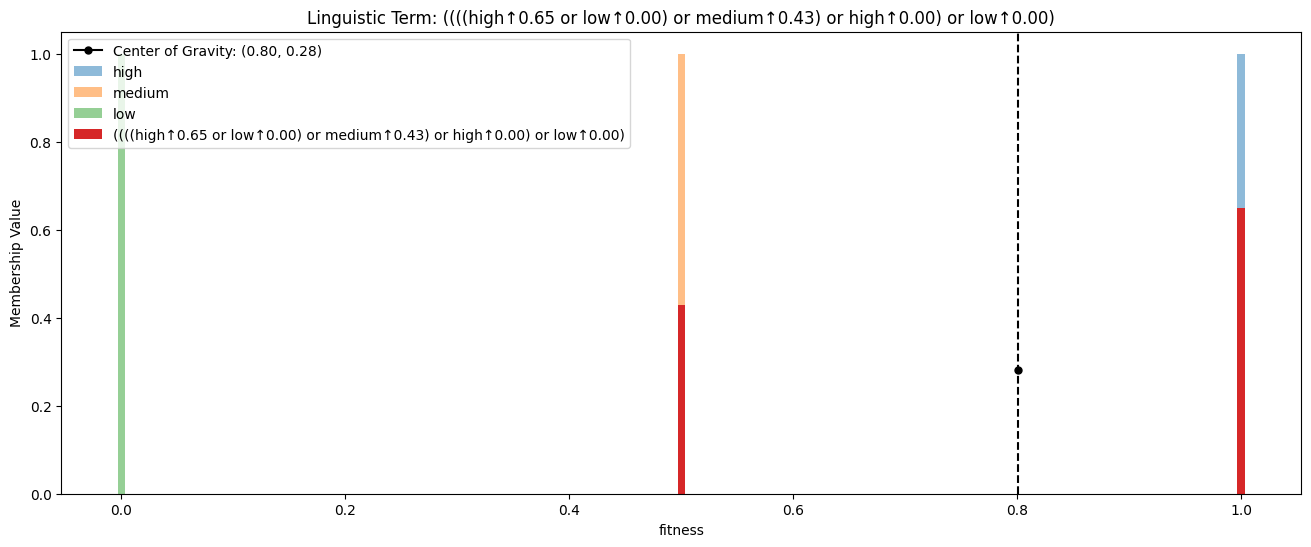

In [74]:
output_membership= fs.applyRules({"age": 27, "height": 170})

fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

output_membership.plot(ax)

ax.legend()

# Plot Decision Surface

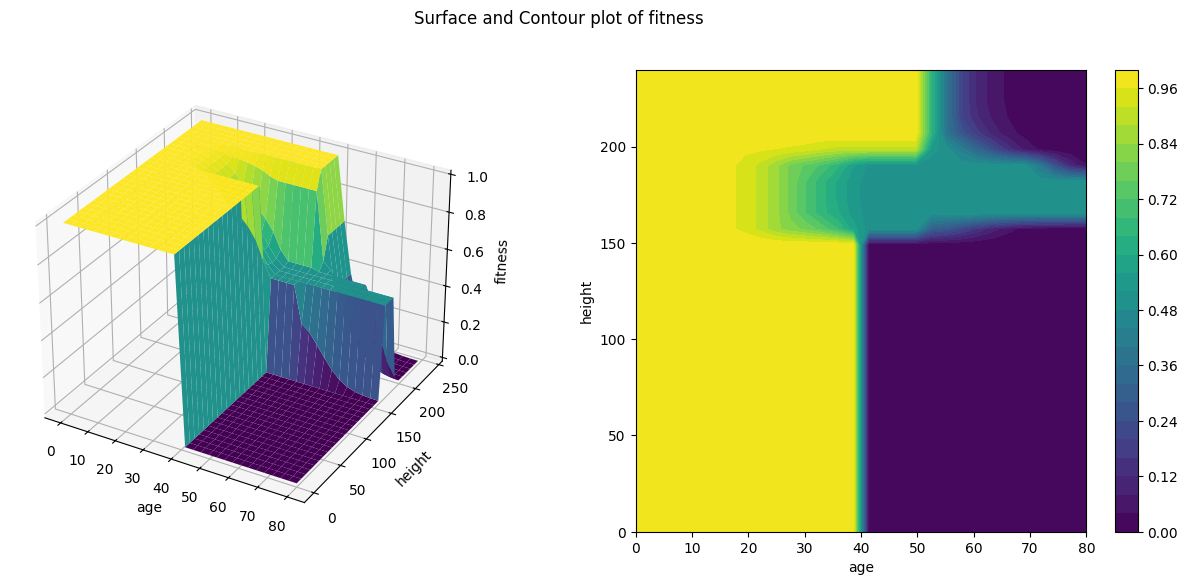

In [75]:
plot3D_surface(fs.getInputCrispSets(), lambda data: fs.predict(data) , {"x": "age", "y": "height", "z":"fitness"}, mesh=30, contour_levels=30);

---
---
---

# Example from Matlab

https://de.mathworks.com/help/fuzzy/building-systems-with-fuzzy-logic-toolbox-software.html 

In [76]:
service_crisp_set = CrispSet({("service", make_continuousSet((0, 10)))})
service = LinguisticVariable(service_crisp_set)

food_crisp_set = CrispSet({("food", make_continuousSet((0, 10)))})
food = LinguisticVariable(food_crisp_set)

tip_crisp_set = CrispSet({("tip", make_continuousSet((0, 25)))})
tip = LinguisticVariable(tip_crisp_set)

In [77]:
service.add_linguistic_term(Gaussian("poor", 0, 1.5))
service.add_linguistic_term(Gaussian("good", 5, 1.5))
service.add_linguistic_term(Gaussian("excellent", 10, 1.5))

food.add_linguistic_term(Trapezoid("rancid", 0, 0, 1, 3))
food.add_linguistic_term(Trapezoid("delicious", 7, 9, 10, 10))

tip.add_linguistic_term(Triangle("cheap", 5, 5))
tip.add_linguistic_term(Triangle("average", 15, 5))
tip.add_linguistic_term(Triangle("generous", 25, 5))

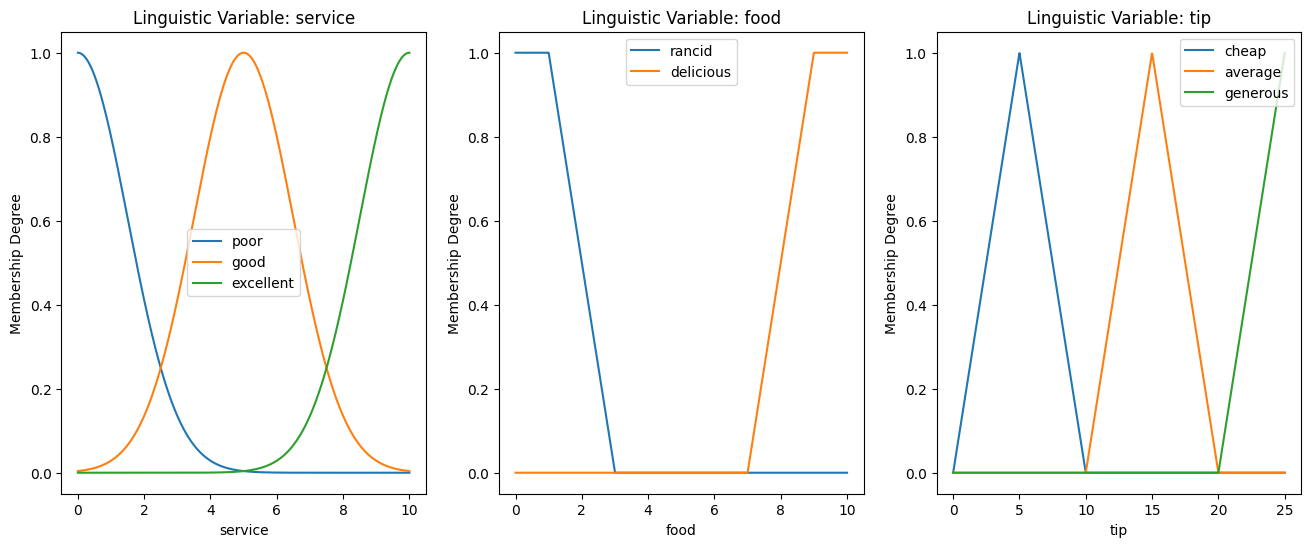

In [78]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(16, 6)

service.plot(ax[0])
food.plot(ax[1])
tip.plot(ax[2])

plt.show()

In [79]:
fs = FuzzySystem()

fs.add_rule(FuzzyRule((service=="poor") | (food=="rancid"), tip=="cheap"))
fs.add_rule(FuzzyRule(service=="good", tip=="average"))
fs.add_rule(FuzzyRule((service=="excellent") | (food=="delicious"), tip=="generous"))

fs

FuzzySystem with rules:

FuzzyRule(IF FuzzySet({('food', <__main__.Set object at 0x7f2deba36560>), ('service', <__main__.Set object at 0x7f2deba390c0>)} -> (poor or rancid)) THEN FuzzySet({('tip', <__main__.Set object at 0x7f2deba35d50>)} -> cheap))
FuzzyRule(IF FuzzySet({('service', <__main__.Set object at 0x7f2deba390c0>)} -> good) THEN FuzzySet({('tip', <__main__.Set object at 0x7f2deba35d50>)} -> average))
FuzzyRule(IF FuzzySet({('food', <__main__.Set object at 0x7f2deba36560>), ('service', <__main__.Set object at 0x7f2deba390c0>)} -> (excellent or delicious)) THEN FuzzySet({('tip', <__main__.Set object at 0x7f2deba35d50>)} -> generous))

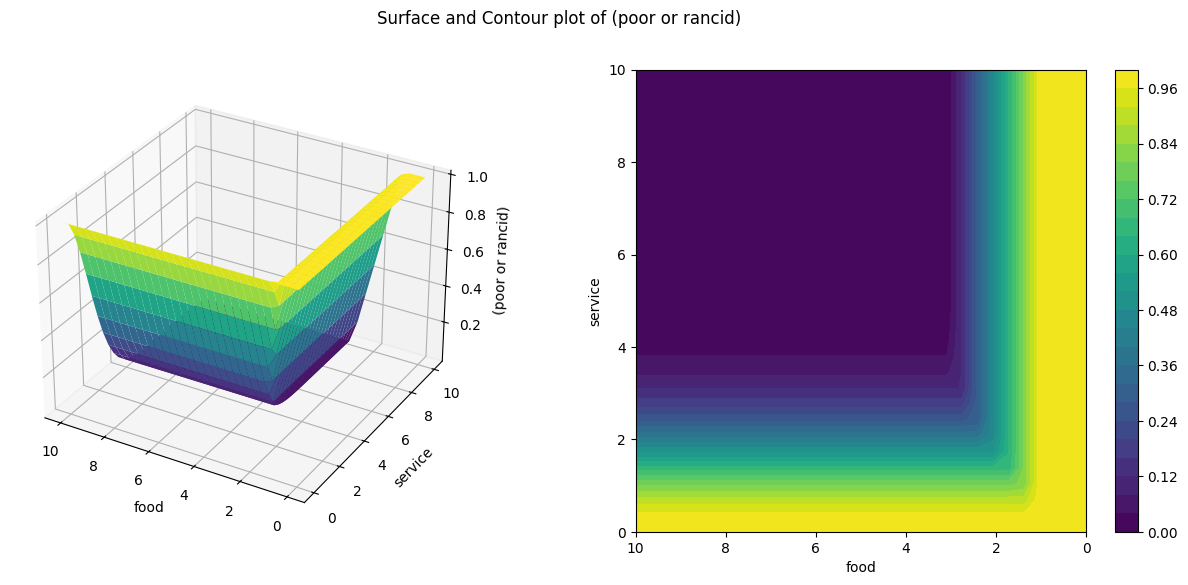

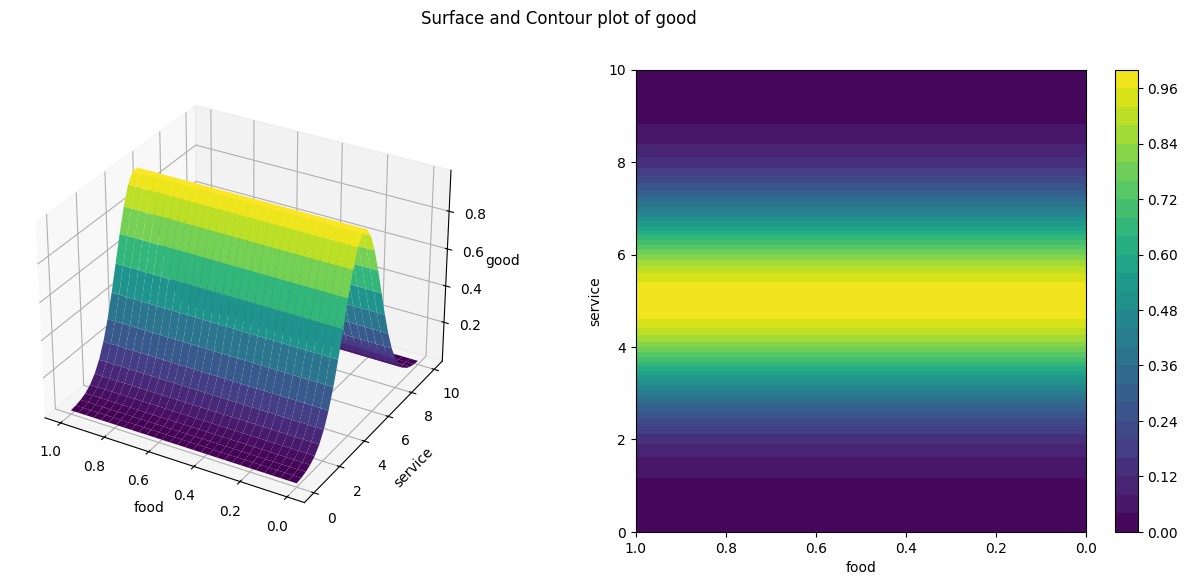

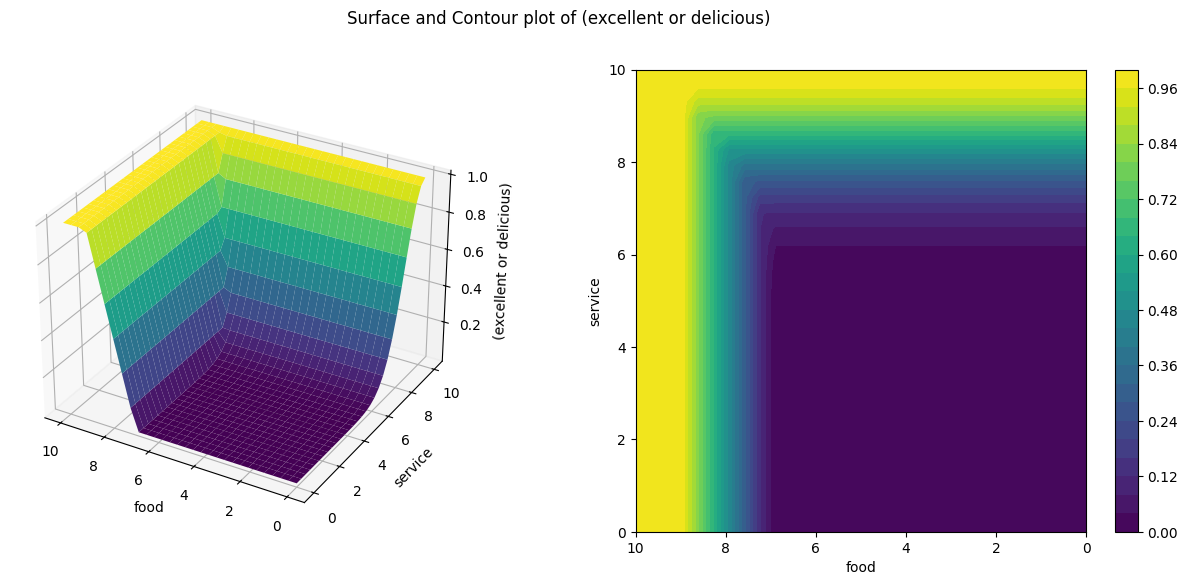

In [80]:
for rule in fs.rules:
    fig=rule.plot({"x": "food", "y": "service"})
    (xl,xh)=fig.get_axes()[1].get_xlim()
    fig.get_axes()[1].set_xlim((xh,xl))
    (xl,xh)=fig.get_axes()[0].get_xlim()
    fig.get_axes()[0].set_xlim((xh,xl))

# Predict Single Values

In [81]:
data={"service": 7, "food": 8}
prediction_of_tip= fs.predict(data)

print(f"Prediction of tip: {prediction_of_tip:.2f} at {data}")

Prediction of tip: 18.02 at {'service': 7, 'food': 8}


# Create Decision Surface

(10.0, 0.0)

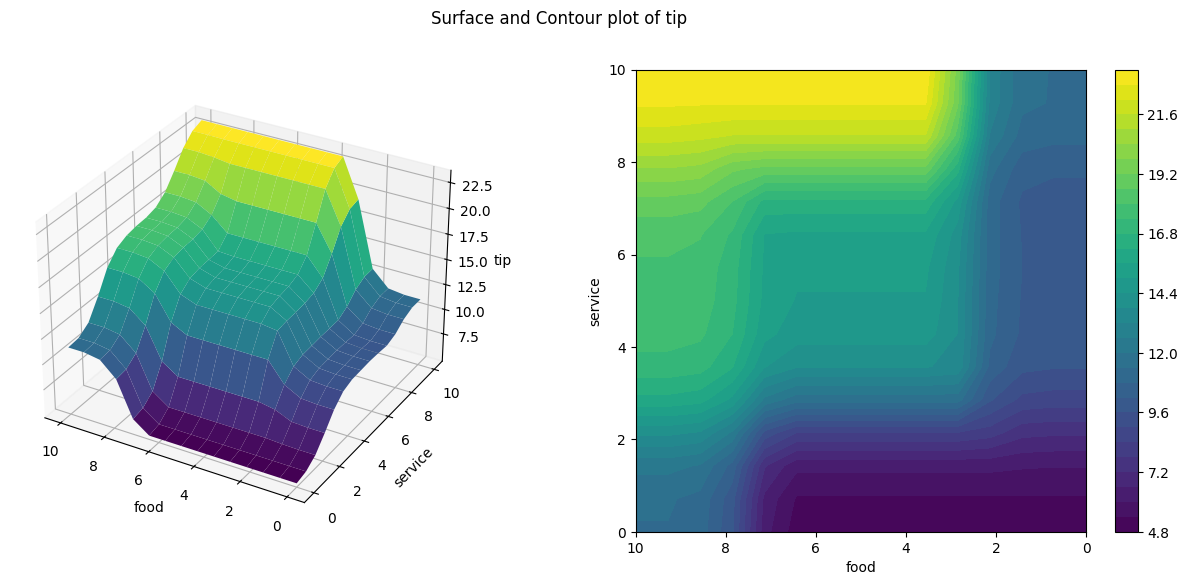

In [82]:
fig=plot3D_surface(fs.getInputCrispSets(), lambda data: fs.predict(data) , {"x": "food", "y": "service","z":"tip"}, mesh=15)

# invert x axis to fit matlab image
(xl,xh)=fig.get_axes()[1].get_xlim()
fig.get_axes()[1].set_xlim((xh,xl))
(xl,xh)=fig.get_axes()[0].get_xlim()
fig.get_axes()[0].set_xlim((xh,xl))

# Predict Single Value

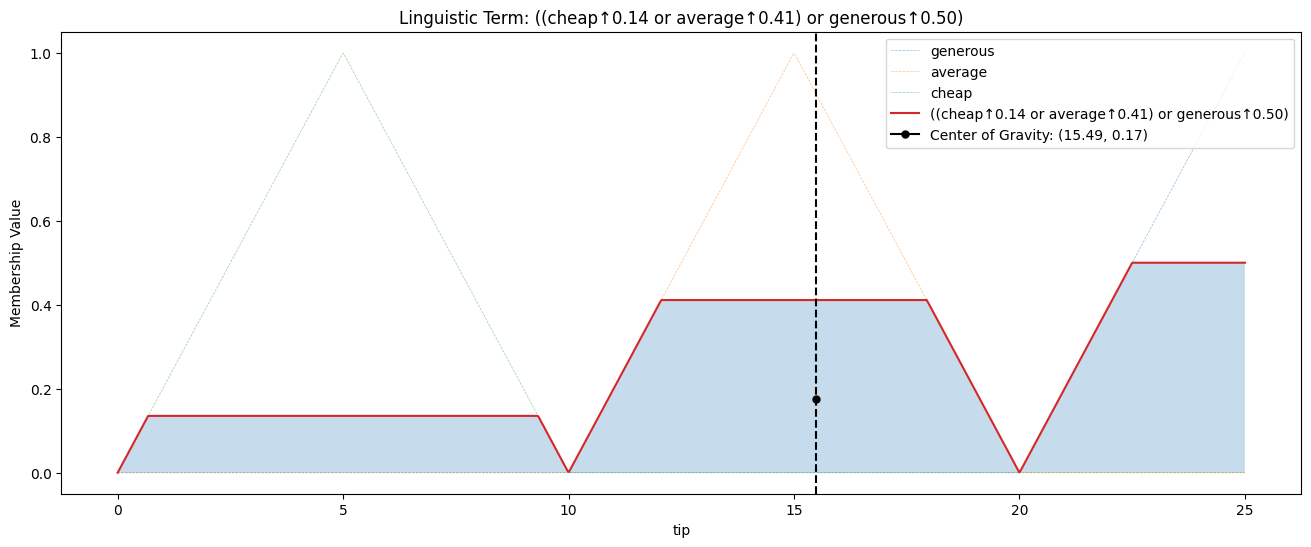

In [83]:
output_membership = fs.applyRules({"food": 8, "service": 3})

fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

output_membership.plot(ax)

ax.legend()